<a href="https://colab.research.google.com/github/73gon/bitcoin-forecasting-using-ml/blob/main/bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### installations and imports

In [1]:
from datetime import datetime, timedelta
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
import praw
import requests
import pandas as pd
import numpy as np
import time
import logging
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

c:\Users\malik\.conda\envs\bitcoin\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\malik\AppData\Local\Temp\ipykernel_2368\3763086780.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


### fetch historical bitcoin data

In [ ]:
def get_binance_data(symbol, interval, start_str, end_str=None):
    base_url = "https://api.binance.com"
    endpoint = "/api/v3/klines"

    start_ts = int(pd.to_datetime(start_str).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_str).timestamp() * 1000) if end_str else None

    data = []
    count = 0

    while True:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ts,
            'limit': 1000
        }
        if end_ts:
            params['endTime'] = end_ts

        try:
            response = requests.get(base_url + endpoint, params=params)
            response.raise_for_status()

            results = response.json()

            if not results:
                break

            data.extend(results)

            start_ts = results[-1][0] + 1

            count += len(results)

            if len(results) < 1000:
                break

        except requests.exceptions.HTTPError as err:
            if response.status_code == 429:
                print("Rate limit exceeded. Waiting before retrying...")
                time.sleep(60)  # Wait 1 minute before retrying
            else:
                raise err

    return data

def save_to_csv(data, filename):
    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume', 'ignore'
    ]
    df = pd.DataFrame(data, columns=columns)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.to_csv(filename, index=False)

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1m"
    start_date = "2010-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")

    print("Starting data fetch...")
    data = get_binance_data(symbol, interval, start_date, end_date)
    print("Data fetch complete. Saving to CSV...")
    save_to_csv(data, 'bitcoin_dataset.csv')

### initialization sentiment model and configuration of reddit api

In [ ]:
# Initialize sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
max_length = 512  # Roberta's maximum sequence length


# Reddit API credentials
client_id = '-DikpAFUeeajlFFyWTBqUg'
client_secret = 'yZu1rPuBINVPuI7LuugQybGwtX1Cdg'
user_agent = 'bitcoin data'
username = '73malik'
password = 'Stapler437581'

# Create Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password,
    check_for_async=False
)

# Subreddit and Keyword definition
subreddit_name = 'all'
keywords = ['bitcoin price prediction', 'bitcoin market analysis', 'bitcoin trend', 'bitcoin forecast', 'bitcoin news']


### retrieve reddit posts

In [ ]:
# Fetch and analyze Reddit posts
def fetch_reddit_posts(subreddit_name, keywords, start_date, end_date, total_limit=1000, score_threshold=10):
    posts = []
    requests_per_minute = 90  # Adjust this based on the actual API limit
    counter = 0
    current_date = start_date

    while current_date <= end_date:
        for keyword in keywords:
            logging.info(f"Fetching posts for keyword: {keyword} on date: {current_date.strftime('%Y-%m-%d')}")
            search_query = f"{keyword} timestamp:{int(current_date.timestamp())}..{int((current_date + timedelta(days=1)).timestamp())}"

            try:
                submissions = reddit.subreddit(subreddit_name).search(search_query, sort='new', limit=total_limit)
                for submission in submissions:
                    if counter >= total_limit:
                        break
                    if submission.score > score_threshold:
                        created_date = datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                        text = submission.title + " " + submission.selftext
                        sentiment = sentiment_pipeline(text)[0]['label']
                        posts.append({
                            'created': created_date,
                            'title': submission.title,
                            'score': submission.score,
                            'url': submission.url,
                            'content': submission.selftext,
                            'sentiment': sentiment
                        })
                        counter += 1
                        logging.info(f"Fetched post {counter}: {submission.title}")

                    if counter > 0 and counter % requests_per_minute == 0:
                        logging.info(f"Pausing to respect rate limit after {counter} requests.")
                        time.sleep(60)  # Sleep to respect rate limit

                logging.info(f"Finished fetching posts for keyword: {keyword}")

            except Exception as e:
                logging.error(f"Error fetching posts for keyword {keyword}: {e}")
                time.sleep(60)  # Sleep for 1 minute before retrying

        current_date += timedelta(days=1)
        time.sleep(1)  # Sleep to avoid rate limit issues

    logging.info(f"Total posts fetched: {len(posts)}")
    return pd.DataFrame(posts)

# Define the start and end dates for fetching posts
start_date = datetime(2024, 1, 1)  # Adjusted start date to cover a longer period
end_date = datetime(2024, 5, 29)   # Example end date

# Fetch new posts
new_posts_df = fetch_reddit_posts(subreddit_name, keywords, start_date, end_date)

# Save the new posts DataFrame to CSV (replacing old data)
new_posts_df.to_csv('reddit_posts.csv', index=False)
logging.info(f"Total posts processed: {len(new_posts_df)}")
logging.info(f"Total unique posts: {len(new_posts_df)}")

### prepare data

In [2]:
# Load the data
price_df = pd.read_csv('bitcoin_dataset.csv')
sentiment_df = pd.read_csv('reddit_posts.csv')

sentiment_df['created'] = pd.to_datetime(sentiment_df['created'])
price_df['open_time'] = pd.to_datetime(price_df['open_time'])

sentiment_df = sentiment_df.sort_values('created')

merged_df = pd.merge_asof(price_df, sentiment_df, left_on='open_time', right_on='created', direction='backward')

sentiment_mapping = {'LABEL_2': 1, 'LABEL_1': 0, 'LABEL_0': -1}
merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_mapping)

In [3]:
sequence_length=60

data = merged_df[['close', 'sentiment_score']].values
x, y = [], []

for i in range(len(data) - sequence_length):
    x.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length][0])

x, y = np.array(x), np.array(y)

In [4]:
# Manually split based on time
split_index = int(len(x) * 0.8)
x_train_val, x_test = x[:split_index], x[split_index:]
y_train_val, y_test = y[:split_index], y[split_index:]

# Further split the training/validation set into training and validation sets
split_index_val = int(len(x_train_val) * 0.8)
x_train, x_val = x_train_val[:split_index_val], x_train_val[split_index_val:]
y_train, y_val = y_train_val[:split_index_val], y_train_val[split_index_val:]

# Print shapes to verify
print(f"Training set shapes: x_train={x_train.shape}, y_train={y_train.shape}")
print(f"Validation set shapes: x_val={x_val.shape}, y_val={y_val.shape}")
print(f"Test set shapes: x_test={x_test.shape}, y_test={y_test.shape}")



Training set shapes: x_train=(2277087, 60, 2), y_train=(2277087,)
Validation set shapes: x_val=(569272, 60, 2), y_val=(569272,)
Test set shapes: x_test=(711590, 60, 2), y_test=(711590,)


In [5]:
# Scaling the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

#reshape and sclae the data x
num_samples, num_timesteps, num_features = x_train.shape

x_train_reshaped = x_train.reshape(-1, num_features)  # (samples * timesteps, features)
x_val_reshaped = x_val.reshape(-1, num_features)
x_test_reshaped = x_test.reshape(-1, num_features)

scaler_x.fit(x_train_reshaped)

x_train_scaled = scaler_x.transform(x_train_reshaped).reshape(num_samples, num_timesteps, num_features)
x_val_scaled = scaler_x.transform(x_val_reshaped).reshape(x_val.shape)
x_test_scaled = scaler_x.transform(x_test_reshaped).reshape(x_test.shape)

#reshape and scale the data y

y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

scaler_y.fit(y_train_reshaped)

y_train_scaled = scaler_y.transform(y_train_reshaped)
y_val_scaled = scaler_y.transform(y_val_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


c:\Users\malik\.conda\envs\bitcoin\lib\site-packages\sklearn\utils\_array_api.py:696: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\malik\.conda\envs\bitcoin\lib\site-packages\sklearn\utils\_array_api.py:713: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


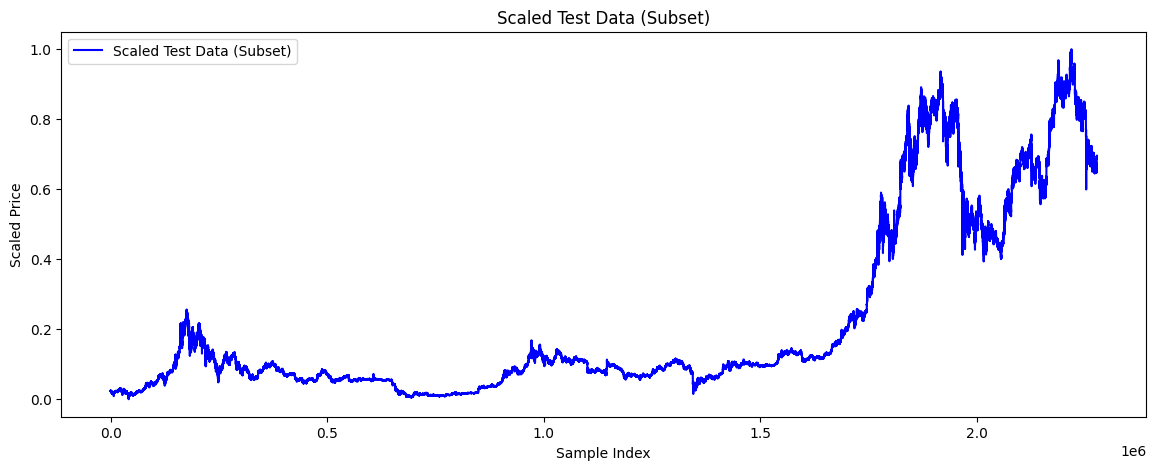

In [6]:
# what to plot
plot_data = y_train_scaled

# Verify the scaled test data
plt.figure(figsize=(14, 5))
plt.plot(range(len(plot_data)), plot_data[:len(plot_data)], color='blue', label='Scaled Test Data (Subset)')
plt.title('Scaled Test Data (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

### build and train lstm model

In [43]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
tf.config.list_physical_devices('GPU')

TensorFlow version: 2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Assuming x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled are pre-defined and properly scaled

# Define the hypermodel directly
hp = HyperParameters()

def build_model(hp):
    input_layer = Input(shape=(x_train_scaled.shape[1], x_train_scaled.shape[2]), name='input_14')
    
    lstm_out_1 = LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                      return_sequences=True, 
                      activation='tanh', 
                      recurrent_activation='sigmoid', 
                      dropout=hp.Float('dropout_1', 0.1, 0.5, step=0.1))(input_layer)
    
    attention_out = Attention()([lstm_out_1, lstm_out_1])
    dropout_1 = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(attention_out)
    
    lstm_out_2 = LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                      return_sequences=False, 
                      activation='tanh', 
                      recurrent_activation='sigmoid', 
                      dropout=hp.Float('dropout_3', 0.1, 0.5, step=0.1))(dropout_1)
    
    dropout_2 = Dropout(hp.Float('dropout_4', 0.1, 0.5, step=0.1))(lstm_out_2)
    
    dense_1 = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_2)
    output_layer = Dense(1, dtype='float32')(dense_1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    
    return model

# Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='bitcoin_lstm'
)

tuner.search_space_summary()

tuner.search(x_train_scaled, y_train_scaled, 
             epochs=50, 
             validation_data=(x_val_scaled, y_val_scaled),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units_1')} with a dropout rate of {best_hps.get('dropout_1')}. 
The optimal number of units in the second LSTM layer is {best_hps.get('units_2')} with a dropout rate of {best_hps.get('dropout_3')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the final model with best hyperparameters
input_layer = Input(shape=(x_train_scaled.shape[1], x_train_scaled.shape[2]))
lstm_out_1 = LSTM(best_hps.get('units_1'), return_sequences=True, activation='tanh', recurrent_activation='sigmoid', dropout=best_hps.get('dropout_1'))(input_layer)
attention_out = Attention()([lstm_out_1, lstm_out_1])
dropout_1 = Dropout(best_hps.get('dropout_2'))(attention_out)

lstm_out_2 = LSTM(best_hps.get('units_2'), return_sequences=False, activation='tanh', recurrent_activation='sigmoid', dropout=best_hps.get('dropout_3'))(dropout_1)
dropout_2 = Dropout(best_hps.get('dropout_4'))(lstm_out_2)

dense_1 = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_2)
output_layer = Dense(1, dtype='float32')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=best_hps.get('learning_rate'))
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
history = model.fit(x_train_scaled, y_train_scaled, 
                    batch_size=8192, 
                    epochs=50, 
                    validation_data=(x_val_scaled, y_val_scaled), 
                    callbacks=[early_stopping, lr_schedule])

# Save the trained model
model.save('lstm_model_with_attention.keras')

Search space summary
Default search space size: 7
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_4 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
288               |288     

KeyboardInterrupt: 

In [8]:
# Build the LSTM model   ------------ TODO
input_shape = (x_train_scaled.shape[1], x_train_scaled.shape[2])

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0, use_bias=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', dropout=0.3, recurrent_dropout=0, use_bias=True))
model.add(Dropout(0.3))
model.add(Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1, dtype='float32'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
model.fit(x_train_scaled, y_train_scaled, batch_size=8192, epochs=50,validation_data=(x_val_scaled, y_val_scaled), callbacks=[early_stopping, lr_schedule])

# Save the trained model in the newer Keras format
model.save('lstm_model.keras')

Epoch 1/50
278/278 [==============================] - 41s 135ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/50
278/278 [==============================] - 32s 113ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 3/50
278/278 [==============================] - 35s 127ms/step - loss: nan - val_loss: nan - lr: 1.0000e-04


In [7]:
# Build the LSTM model   ------------ TODO
input_shape = (x_train_scaled.shape[1], x_train_scaled.shape[2])

# Define model architecture
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, use_bias=True), input_shape=input_shape))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, use_bias=True)))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'))
model.add(Dense(1, dtype='float32'))

# Define optimizer and compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model on the test set
performance = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Set MAE: {performance[1]}')

Epoch 1/100
 500/8895 [>.............................] - ETA: 7:13 - loss: nan

KeyboardInterrupt: 

In [13]:
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 32)            4480      
                                                                 
 dropout_2 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trai

### predict future prices

In [14]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
lstm_model = load_model('lstm_model.keras')

# Prepare the last sequence for prediction
sequence_length = 60

# Ensure the last sequence is correctly sized (60, 2)
last_sequence = x[-1]  # This should be a single sequence of shape (60, 2)

# Verify the shape of the last_sequence
print(f"last_sequence shape: {last_sequence.shape}")

# Check for NaN values in the last_sequence
if np.isnan(last_sequence).any():
    raise ValueError("last_sequence contains NaN values")

# Initialize the list to store predictions
predictions = []

# Predict minute-level data for the next day (24 * 60 minutes)
minutes_in_a_day = 24 * 60
for i in range(minutes_in_a_day):
    # Reshape the last sequence to match the model input
    last_sequence_scaled = last_sequence.reshape(1, sequence_length, 2)
    
    # Predict the next value
    predicted_price_scaled = lstm_model.predict(last_sequence_scaled)
    
    # Debugging prints
    print(f"Iteration {i}: last_sequence_scaled = {last_sequence_scaled}")
    print(f"Iteration {i}: predicted_price_scaled = {predicted_price_scaled}")
    
    # Check for NaN values in the prediction
    if np.isnan(predicted_price_scaled).any():
        raise ValueError("Model prediction contains NaN values")
    
    # Store the prediction
    predictions.append(predicted_price_scaled[0, 0])
    
    # Update the last sequence by appending the predicted value and removing the first value
    next_sequence = np.append(last_sequence[1:], [[predicted_price_scaled[0, 0], last_sequence[-1, 1]]], axis=0)
    last_sequence = next_sequence

# Inverse transform the predictions to the original scale
predicted_prices = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Check for NaN values in the predicted prices
if np.isnan(predicted_prices).any():
    raise ValueError("Predicted prices contain NaN values")

# Verify the predicted prices
print(f"Predicted prices: {predicted_prices}")

last_sequence shape: (60, 2)
1/1 [==============================] - 1s 774ms/step
Iteration 0: last_sequence_scaled = [[[68600.       0.  ]
  [68607.58     0.  ]
  [68590.01     0.  ]
  [68615.06     0.  ]
  [68590.       0.  ]
  [68564.       0.  ]
  [68526.55     0.  ]
  [68500.       0.  ]
  [68484.61     0.  ]
  [68434.       0.  ]
  [68429.95     0.  ]
  [68416.78     0.  ]
  [68410.       0.  ]
  [68378.99     0.  ]
  [68413.42     0.  ]
  [68400.97     0.  ]
  [68416.       0.  ]
  [68424.62     0.  ]
  [68438.56     0.  ]
  [68430.01     0.  ]
  [68414.81     0.  ]
  [68422.06     0.  ]
  [68422.07     0.  ]
  [68433.39     0.  ]
  [68460.       0.  ]
  [68451.76     0.  ]
  [68454.27     0.  ]
  [68461.79     0.  ]
  [68463.99     0.  ]
  [68480.       0.  ]
  [68475.68     0.  ]
  [68474.01     0.  ]
  [68452.23     0.  ]
  [68460.12     0.  ]
  [68452.24     0.  ]
  [68450.36     0.  ]
  [68423.8      0.  ]
  [68433.99     0.  ]
  [68425.11     0.  ]
  [68424.       0.  ]
  

ValueError: Model prediction contains NaN values

C:\Users\malik\AppData\Local\Temp\ipykernel_2368\3810318507.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_range = pd.date_range(last_date + pd.Timedelta(minutes=1), periods=minutes_in_a_day, freq='T')


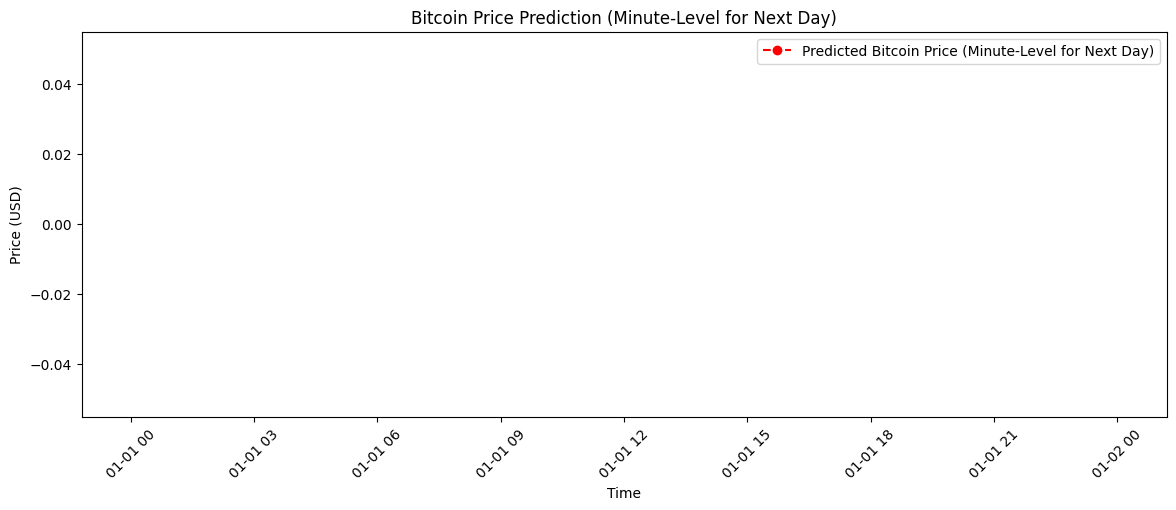

In [11]:
# Prepare the time axis for the actual and predicted period
last_date = merged_df['open_time'].iloc[-1]  # last date of actual data for prediction start
minute_range = pd.date_range(last_date + pd.Timedelta(minutes=1), periods=minutes_in_a_day, freq='T')

# Plot the predicted prices for the next day
plt.figure(figsize=(14, 5))
plt.plot(minute_range, predicted_prices, color='red', marker='o', linestyle='dashed', label='Predicted Bitcoin Price (Minute-Level for Next Day)')
plt.title('Bitcoin Price Prediction (Minute-Level for Next Day)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [47]:
# Load the trained model
lstm_model = load_model('lstm_model.keras')

# Predict future prices using the test data
predictions = lstm_model.predict(x_test_scaled)

# Inverse transform the predictions and actual prices
predicted_prices = scaler_y.inverse_transform(predictions).flatten()
actual_prices = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


22238/22238 [==============================] - 132s 6ms/step


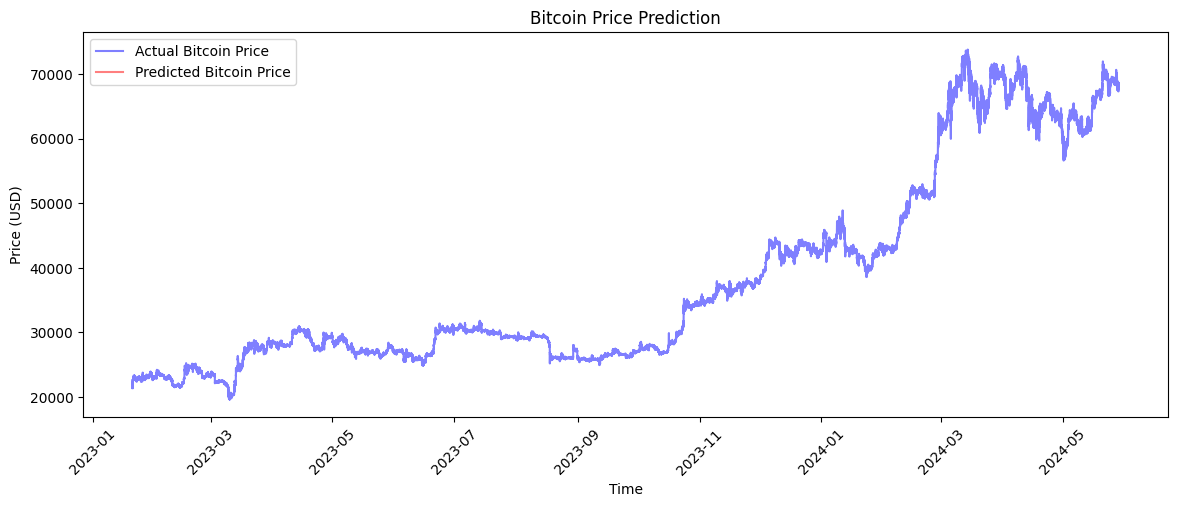

In [ ]:

# Prepare the time axis using the original timestamps
# Assuming you have 'timestamp' column in your price_df which is your date-time series
time_axis = pd.to_datetime(price_df['open_time'].iloc[len(price_df) - len(predicted_prices):])

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(time_axis, actual_prices, color='blue', alpha=0.5, label='Actual Bitcoin Price')
plt.plot(time_axis, predicted_prices, color='red', alpha=0.5, label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming x_scaled and y_scaled are your preprocessed and scaled data

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

# Build and train the LSTM model
input_shape = (x_train.shape[1], x_train.shape[2])
lstm_model = build_lstm_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
lstm_model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_schedule])

# Make predictions
predictions = lstm_model.predict(x_test)

# Unscale the predictions and actual values
actual_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler_y.inverse_transform(predictions).flatten()

# Calculate AOI
def calculate_aoi(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)

    intersection_area = np.sum(np.minimum(actual, predicted))
    total_area_actual = np.sum(actual)
    total_area_predicted = np.sum(predicted)
    total_area = total_area_actual + total_area_predicted

    aoi = 2 * intersection_area / total_area
    return aoi

aoi_value = calculate_aoi(actual_prices, predicted_prices)
print(f"Average Overlap Index (AOI): {aoi_value:.4f}")